In [187]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [188]:
#clones_file = "cdr3-clones-AB-ADA-IGH_HUMAN-after-reassignment.csv" # 3MB file (run28)
#pt_file = "20180514_Run028_pt-table_CORRECT.csv"
#plotfile = "run28-AB-ADA-IGH_HUMAN.pdf"

#clones_file = "cdr3-clones-Eomes-TRB_MOUSE-after-reassignment.csv"  # 14 MB (run28)
#pt_file = "20180514_Run028_pt-table_CORRECT.csv"
#plotfile = "run28-Eomes-TRB_MOUSE.pdf"

#clones_file = "cdr3-clones-Prairi-IGH_HUMAN-after-reassignment.csv" # 22 MB (run25)
#pt_file = "20180326_RUN25_pt.table.csv"
#plotfile = "run25-Prairi-IGH_HUMAN.pdf"

clones_file = "cdr3-clones-AB-RBF-TRB_HUMAN-after-reassignment.csv" # 300 MB file (run25)
pt_file = "20180326_RUN25_pt.table.csv"
plotfile = "run25-AB-RBF-TRB_HUMAN.pdf"

## Import clonesdata

In [189]:
clones = pd.read_csv(clones_file, sep="\t")

In [190]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,read_perc,umi_perc
0,AB-RBF002-Tu_S1,ACGTACGT,CASSAVAGGYNEQFFG,574,517,TRBV6-2+TRBV6-3,"TRBJ2-1,TRBJ2-5,TRBJ2-7",0.876577,0.992056
1,AB-RBF002-Tu_S1,ACGTACGT,CASSLVTDTQYFG,419,333,TRBV11-2,TRBJ2-3,0.639870,0.638984
2,AB-RBF002-Tu_S1,ACGTACGT,CSGARGEGTEAFFG,327,216,TRBV29-1,TRBJ1-1,0.499374,0.414476
3,AB-RBF002-Tu_S1,ACGTACGT,CASSTSPRGYTFG,311,247,TRBV19,TRBJ1-2,0.474940,0.473961
4,AB-RBF002-Tu_S1,ACGTACGT,CSVEEGGYTFG,297,189,TRBV29-1,TRBJ1-2,0.453560,0.362666


## Import patient table

In [191]:
pt = pd.read_csv(pt_file, sep=";")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})

In [192]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [193]:
pt.head()

,Sample,Patient
0,AB-RBF002-Tu_S1,17-02-0005
1,AB-RBF003-Tu_S2,17-02-0005
2,AB-RBF007-Tu_S3,17-02-0005
3,AB-RBF009-Tu_S4,17-02-0005
4,AB-RBF012-Tu_S5,28-01-0027


## Merge clones with pt

In [194]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df = df.set_index(['Patient', 'Sample'])
df.head()

MID           cdr3pep  freq  uniq_umis  \
Patient    Sample                                                         
17-02-0005 AB-RBF002-Tu_S1  ACGTACGT  CASSAVAGGYNEQFFG   574        517   
           AB-RBF002-Tu_S1  ACGTACGT     CASSLVTDTQYFG   419        333   
           AB-RBF002-Tu_S1  ACGTACGT    CSGARGEGTEAFFG   327        216   
           AB-RBF002-Tu_S1  ACGTACGT     CASSTSPRGYTFG   311        247   
           AB-RBF002-Tu_S1  ACGTACGT       CSVEEGGYTFG   297        189   

                                      V_sub                    J_sub  \
Patient    Sample                                                      
17-02-0005 AB-RBF002-Tu_S1  TRBV6-2+TRBV6-3  TRBJ2-1,TRBJ2-5,TRBJ2-7   
           AB-RBF002-Tu_S1         TRBV11-2                  TRBJ2-3   
           AB-RBF002-Tu_S1         TRBV29-1                  TRBJ1-1   
           AB-RBF002-Tu_S1           TRBV19                  TRBJ1-2   
           AB-RBF002-Tu_S1         TRBV29-1                  TRBJ1-2   

                            read_perc  umi_perc  
Patient    Sample                                
17-02-0005 AB-RBF002-Tu_S1   0.876577  0.992056  
           AB-RBF002-Tu_S1   0.639870  0.638984  
           AB-RBF002-Tu_S1   0.499374  0.414476  
           AB-RBF002-Tu_S1   0.474940  0.473961  
           AB-RBF002-Tu_S1   0.453560  0.362666

## Count overlapping clones between samples

In [195]:
# Sort index for better performance
df = df.sort_index()

# Make empty data frame for the distance matrix
colnames = list(set(df.index))
colnames
colnames.sort()
overlap = pd.DataFrame(index=colnames, columns=colnames, dtype=np.float)

In [196]:
# Function to count overlapping elements (cdr3pep): Jaccard index
jaccard = lambda x, y: len(set(x).intersection(set(y))) / len(set(x).union(set(y)))

In [197]:
# Function to count overlapping elements (cdr3pep): Sorensen index
sorensen = lambda x, y: 2 * len(set(x).intersection(set(y))) / (len(set(x)) + len(set(y)))

In [200]:
# Function to count overlapping elements, taking abundance into account: Bray-Curtis
def bray_curtis(x,y):
    '''
    From: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.1334&rep=rep1&type=pdf
    In: x (dataframe), y (dataframe)
    Out: similarity (number)
    '''
    #x = df.loc[('M5', 'Eomes-01_S9')][['cdr3pep', 'read_perc']]
    #y = df.loc[('M5', 'Eomes-02_S10')][['cdr3pep', 'read_perc']]
    merged = pd.merge(x, y, how='outer', on = 'cdr3pep')
    merged = merged.fillna(0)   # Replace NaN with 0
    merged['minimum'] = [i for i in map(min, merged['freq_x'], merged['freq_y'])]
    similarity = 2 * sum(merged['minimum']) / (sum(merged['freq_x']) + sum(merged['freq_y']))
    return(similarity)

In [201]:
# Calculate distance between all samples
for x in overlap.index:
    for y in overlap.index:
        #overlap[x][y] = max(sorensen(df.loc[x]['cdr3pep'], df.loc[y]['cdr3pep']), 0.0000000001)
        overlap[x][y] = max(bray_curtis(df.loc[x][['cdr3pep', 'freq']], df.loc[y][['cdr3pep', 'freq']]), 0.0000000001)

In [202]:
overlap.head()

,"(17-02-0001, AB-RBF207-Tu_S98)","(17-02-0002, AB-RBF208-Tu_S115)","(17-02-0005, AB-RBF002-Tu_S1)","(17-02-0005, AB-RBF003-Tu_S2)","(17-02-0005, AB-RBF007-Tu_S3)","(17-02-0005, AB-RBF009-Tu_S4)","(17-02-0006, AB-RBF209-Tu_S116)","(17-03-0002, AB-RBF210-Tu_S117)","(18-01-0003, AB-RBF163-Tu_S47)","(18-01-0003, AB-RBF171-Tu_S183)",...,"(28-01-0036, AB-RBF066-Tu_S62)","(28-01-0036, AB-RBF071-Tu_S65)","(28-01-0037, AB-RBF223-Tu_S146)","(28-01-0045, AB-RBF045-Tu_S44)","(28-01-0045, AB-RBF057-Tu_S45)","(28-01-0045, AB-RBF068-Tu_S63)","(28-01-0045, AB-RBF069-Tu_S64)","(28-01-0045, AB-RBF072-Tu_S66)","(28-01-0047, AB-RBF227-Tu_S166)","(28-01-0048, AB-RBF231-Tu_S170)"
"(17-02-0001, AB-RBF207-Tu_S98)",1.000000,0.011497,0.015709,0.013020,0.013915,0.014284,0.011711,0.015575,0.012907,0.012635,...,0.013317,0.012330,0.009445,0.009346,0.010828,0.010324,0.010439,0.010613,0.009893,0.012747
"(17-02-0002, AB-RBF208-Tu_S115)",0.011497,1.000000,0.013173,0.011833,0.012046,0.012613,0.011479,0.012441,0.012574,0.012890,...,0.012580,0.011469,0.011469,0.010935,0.010971,0.011584,0.013168,0.012404,0.008947,0.010707
"(17-02-0005, AB-RBF002-Tu_S1)",0.015709,0.013173,1.000000,0.142940,0.161890,0.178233,0.013292,0.016085,0.014623,0.014019,...,0.014644,0.013123,0.011086,0.010465,0.012541,0.012509,0.012810,0.013035,0.009492,0.012647
"(17-02-0005, AB-RBF003-Tu_S2)",0.013020,0.011833,0.142940,1.000000,0.131531,0.154393,0.010783,0.015172,0.013618,0.014090,...,0.015677,0.013694,0.010583,0.010854,0.011349,0.011833,0.013056,0.012227,0.008798,0.011556
"(17-02-0005, AB-RBF007-Tu_S3)",0.013915,0.012046,0.161890,0.131531,1.000000,0.147642,0.011990,0.015473,0.013315,0.013845,...,0.012808,0.012554,0.010024,0.009391,0.011725,0.010797,0.011556,0.011856,0.009555,0.012178


In [203]:
# Replace NaN and zero's with low number
overlap[overlap.isna()] = 0.0000000001
overlap[overlap == 0] = 0.0000000001

## Create a heatmap

In [204]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [205]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

Wrote run25-AB-RBF-TRB_HUMAN.pdf to disk


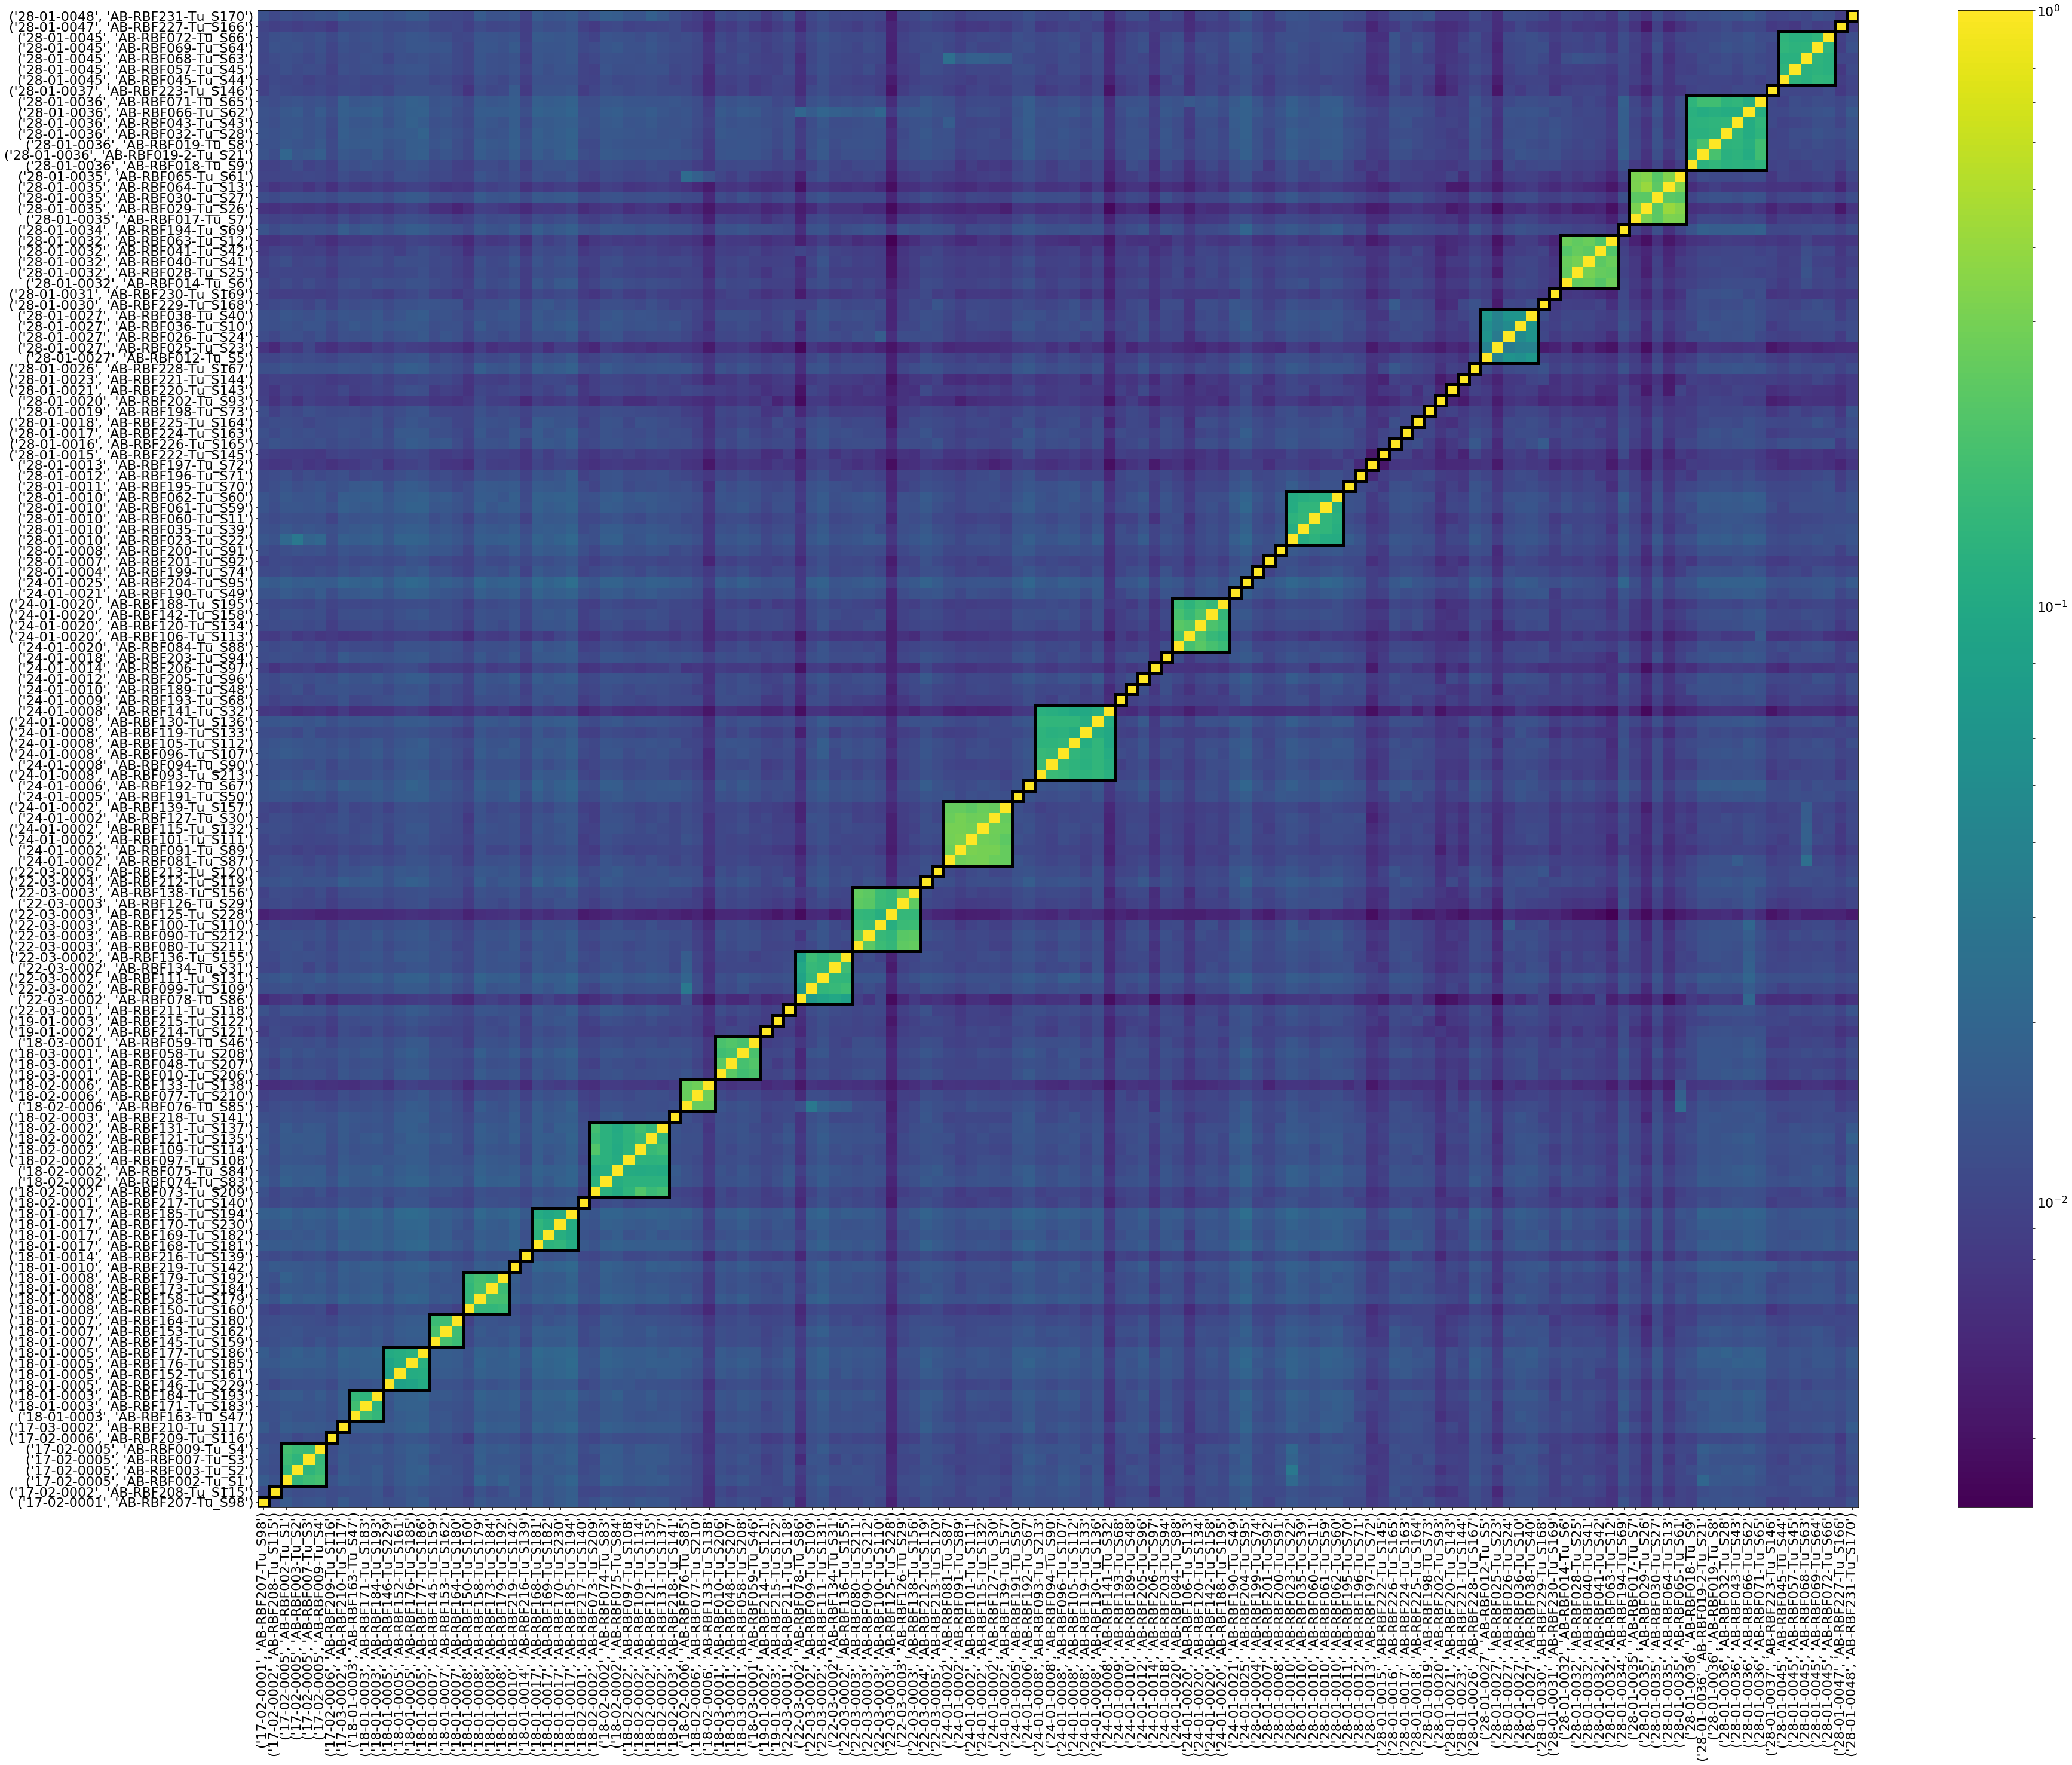

In [206]:
drawHeatmap(overlap)